In [ ]:
# Author: Yuki Rivera
# This notebook contains the code to build & train the lstm model with an encoder-decoder structure.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, TimeDistributed
import pandas as pd
from tensorflow.keras.models import Model, load_model
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback
import matplotlib.pyplot as plt
from tensorflow.keras.losses import sparse_categorical_crossentropy
import numpy as np
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [ ]:
full_data = True
num_of_rows = 10000

In [ ]:
vocab_limit = 15000
enc_max_len = 64  # the prompt length
dec_max_len = 150   # the synopsis length
max_dec_input_length = dec_max_len - 1  # decoder input length

embedding_dim = 128 # output_dim
units = 128   # number of lstm units

batch = 64
repeat = 20 # num of epochs
patience = 3 # early-stopping patience

# total_epochs = 120

custom_learning_rate = 5e-5
adam_optimizer = Adam(learning_rate=custom_learning_rate)

val_ratio = 0.2 # validation set ratio

min_delta = 0.01  # minimum threshold regarded as improvement

dropout_rate = 0.3

### Preprocess the data

In [ ]:
# Cleans text
def clean_text(text):
    return text.lower().strip().replace('\n', ' ')

In [ ]:
# Loads dataset
train_df = pd.read_csv("prompt_synopsis_train.csv")

if not full_data:
    train_df = train_df.sample(n=num_of_rows, random_state=42).reset_index(drop=True)

for col in ['prompt', 'synopsis']:
    train_df[col] = train_df[col].astype(str).apply(clean_text)

In [ ]:
# Define fixed IDs for special tokens.
PAD_ID = 0
OOV_ID = 1
BOS_ID = 2
EOS_ID = 3

# Number of special tokens we manually reserve IDs for.
NUM_SPECIAL_TOKENS_RESERVED = 4 # (PAD, OOV, BOS, EOS)

# The number of actual content words the tokenizer should learn.
num_words_to_fit = vocab_limit - NUM_SPECIAL_TOKENS_RESERVED

In [ ]:
# Instantiates a tokenizer (disabling special character filtering)
tokenizer = Tokenizer(num_words=num_words_to_fit, oov_token='<OOV>', filters='')
# Builds a single shared vocabulary across both the input and the output
tokenizer.fit_on_texts(train_df['prompt'].tolist() + train_df['synopsis'].tolist())

In [ ]:
# Create a new word_index starting from special tokens.
new_word_index = {}
new_index_word = {}

# Assign reserved IDs first
new_word_index["<PAD>"] = PAD_ID
new_index_word[PAD_ID] = "<PAD>"

new_word_index["<OOV>"] = OOV_ID
new_index_word[OOV_ID] = "<OOV>"

new_word_index["<BOS>"] = BOS_ID
new_index_word[BOS_ID] = "<BOS>"

new_word_index["<EOS>"] = EOS_ID
new_index_word[EOS_ID] = "<EOS>"

In [ ]:
# Starts assigning IDs from the next available slot after special tokens.
next_available_id = NUM_SPECIAL_TOKENS_RESERVED
content_words_assigned = 0 # Track how many content words we've assigned

for word, original_id in sorted(tokenizer.word_index.items(), key=lambda item: item[1]):
    # Skips words not in the new word index
    if word in new_word_index:
        continue
    # Assigns the new ID to the content word
    if content_words_assigned < num_words_to_fit:
        new_word_index[word] = next_available_id
        new_index_word[next_available_id] = word
        next_available_id += 1
        content_words_assigned += 1

    else:
        # Breaks the loop once all required content words have been assigned
        break


tokenizer.word_index = new_word_index
tokenizer.index_word = new_index_word

# Ensures the vocab_size for Embedding layer stays the same as the target vocab limit
vocab_size = vocab_limit

### Saves the tokenizer for evaluation later

In [ ]:
# Saves the tokenizer after it has been fitted and checked
with open("tokenizer_LSTM.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

### Converts words into token IDs and creates input sequences

In [ ]:
# Converts each prompt or synopsis into a list of integers
input_seqs = tokenizer.texts_to_sequences(train_df['prompt'])
output_seqs = tokenizer.texts_to_sequences(train_df['synopsis'])

# Adds BOS and EOS tokens to each synopsis sequence 
synopsis_token_ids_augmented = [[BOS_ID] + seq + [EOS_ID] for seq in output_seqs]

# Creates decoder inputs that go into the decoder during training
decoder_input_ids = [seq[:-1] for seq in synopsis_token_ids_augmented]

# Creates decoder targets for loss calculation
decoder_target_ids = [seq[1:] for seq in synopsis_token_ids_augmented]

### Pads the input sequences

In [ ]:
# Encoder input 
padded_input = pad_sequences(input_seqs, maxlen=enc_max_len, truncating='post', padding='post', value=0)

# Decoder input for training
decoder_input_data = pad_sequences(decoder_input_ids, maxlen=max_dec_input_length, truncating='post', padding='post', value=0)

# Decoder target for training (needs to be expanded for sparse_categorical_crossentropy)
decoder_target_data = pad_sequences(decoder_target_ids, maxlen=max_dec_input_length, truncating='post', padding='post', value=0)
decoder_target_data = np.expand_dims(decoder_target_data, axis=-1)

### Defines the LSTM

In [ ]:
#### Encoder ####

# Input layer for the encoder (prompts)
encoder_inputs = Input(shape=(enc_max_len,), name='encoder_input')

# Embedding layer for the encoder inputs
# `mask_zero=True` to ignore padding (token ID 0) during processing.
encoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True, name='encoder_embedding')(encoder_inputs)

# LSTM returns (output_sequence, last_hidden_state, last_cell_state)
encoder_lstm = LSTM(units, return_state=True, name='encoder_lstm')
encoder_outputs, state_h_enc, state_c_enc = encoder_lstm(encoder_embedding)
encoder_states = [state_h_enc, state_c_enc] # LSTM states are (h, c)

#### Decoder ####

# Input layer for the decoder (shifted target synopsis sequences, thus dec_max_len -1 for the shape)
decoder_inputs = Input(shape=(dec_max_len - 1,), name='decoder_input')

# Embedding layer for the decoder inputs.
# `mask_zero=True` is for the decoder's input to ignore padding.
decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True, name='decoder_embedding')(decoder_inputs)

# Decoder LSTM layer.
# `return_sequences=True` ensures that the LSTM outputs a sequence, not just a single final output.
# `initial_state=encoder_states` connects the encoder to the decoder.
decoder_lstm = LSTM(units, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs_sequence, decoder_state_h, decoder_state_c = decoder_lstm(
    decoder_embedding, initial_state=encoder_states
)

# Dense layer at the end of the decoder.
decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_output')
output = decoder_dense(decoder_outputs_sequence)


#### Defines the Encoder-Decoder model ####
model_lstm = Model(inputs=[encoder_inputs, decoder_inputs], outputs=output)

### Configures the model to train

In [ ]:
model_lstm.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Callbacks for saving the best model & early stopping

In [ ]:
model_path = "lstm_model.keras"

In [ ]:
# Set callbacks
checkpoint_cb = ModelCheckpoint(
    filepath=model_path,
    save_best_only=True,  
    monitor='val_loss',   
    mode='min',           
    verbose = 1           
)
earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=patience,
    min_delta=min_delta,
    restore_best_weights=True,
    verbose = 1
)

### Split the data into training and validation sets

In [ ]:
X = [padded_input, decoder_input_data]
y = decoder_target_data

# Perform the split
X_train_encoder, X_val_encoder, X_train_decoder, X_val_decoder, y_train_target, y_val_target = train_test_split(
    X[0], X[1], y, test_size=val_ratio, random_state=42
)

### Trains the model

In [ ]:
full_history = []

In [ ]:
# Combines encoder and decoder inputs for the training set
train_inputs = [X_train_encoder, X_train_decoder]
# Combines encoder and decoder inputs for the validation set
val_inputs = [X_val_encoder, X_val_decoder]

In [ ]:
# trains the model with teacher-forcing
history1 = model_lstm.fit(
    train_inputs,       
    y_train_target,     
    batch_size=batch,
    epochs=repeat,      
    validation_data=(val_inputs, y_val_target), 
    callbacks=[checkpoint_cb, earlystop_cb], 
    verbose=1 
)

Epoch 1/20
753/754 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0490 - loss: 8.4797
Epoch 1: val_loss improved from inf to 6.62977, saving model to lstm_model.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.0490 - loss: 8.4772 - val_accuracy: 0.0534 - val_loss: 6.6298
Epoch 2/20
753/754 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0544 - loss: 6.6161
Epoch 2: val_loss improved from 6.62977 to 6.61194, saving model to lstm_model.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - accuracy: 0.0544 - loss: 6.6161 - val_accuracy: 0.0534 - val_loss: 6.6119
Epoch 3/20
753/754 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0537 - loss: 6.6018
Epoch 3: val_loss improved from 6.61194 to 6.57920, saving model to lstm_model.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - accuracy: 0.0537 - loss: 6.6018 - val_accuracy: 0.0534 - val_loss: 6.5792
Epoch 4/20
753/754 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0541 - loss: 6.5644
Epoch 4: val_loss improved from 6.57920 to 6

### Saves the training history

In [ ]:
full_history.append(history1.history)

In [ ]:
combined = {
    "loss": sum([h["loss"] for h in full_history], []),
    "val_loss": sum([h["val_loss"] for h in full_history], []),
}

In [ ]:
with open("combined_history.pkl", "wb") as f:
    pickle.dump(combined, f)

### Plot the Loss Curve

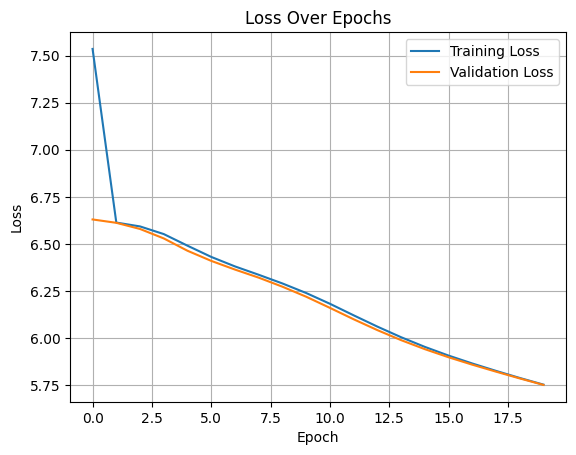

In [ ]:
# Plot training & validation loss
plt.plot(combined['loss'], label='Training Loss')
plt.plot(combined['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("loss_curve_lstm.png")
plt.show()

### Validation perplexity calculation

In [ ]:
model_lstm.load_weights(model_path)

In [ ]:
val_loss, val_accuracy = model_lstm.evaluate(val_inputs, y_val_target, verbose=0)
perplexity = np.exp(val_loss)
print(f"Perplexity: {perplexity:.2f}")

Perplexity: 314.27


### Create a text to record the parameters used as well as the validation perplexity

In [ ]:
parameters = {'epochs':repeat, 'batch_size':batch, 'embedding_dim':embedding_dim,
              'LSTM units':units, 'vocab_limit':vocab_limit, 'learning_rate':custom_learning_rate,'patience':patience,
              'min_delta':min_delta, 'validation_ratio':val_ratio, 'dropout':dropout_rate, 'perplexity':perplexity}

results = ''
for key, value in parameters.items():
    results += "{key}: {value}".format(key=key, value=value)
    results += '\n'

with open('results_LSTM.txt', 'w') as f:
    f.write(results)